In [2]:
suppressMessages(library(scDesign3))
suppressMessages(library(scales))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(Seurat))

In [4]:
output_dir <- './results'

if(!dir.exists(output_dir)){
    dir.create(output_dir, recursive = TRUE)
}


# 读取本地 VISIUM_sce.rds 文件
ref_sce <- readRDS("./VISIUM_sce.rds")


# remove MT genes去除线粒体基因
mt_idx<- grep("mt-",rownames(ref_sce))
if(length(mt_idx)!=0){
    ref_sce <- ref_sce[-mt_idx,]
}

In [5]:
ref_sce

class: SingleCellExperiment 
dim: 995 2696 
metadata(0):
assays(2): counts logcounts
rownames(995): Calb2 Gng4 ... Fndc5 Gda
rowData names(0):
colnames(2696): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCACATCCAGG-1 TTGTTTCCATACAACT-1
colData names(12): orig.ident nCount_Spatial ... spatial2 cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

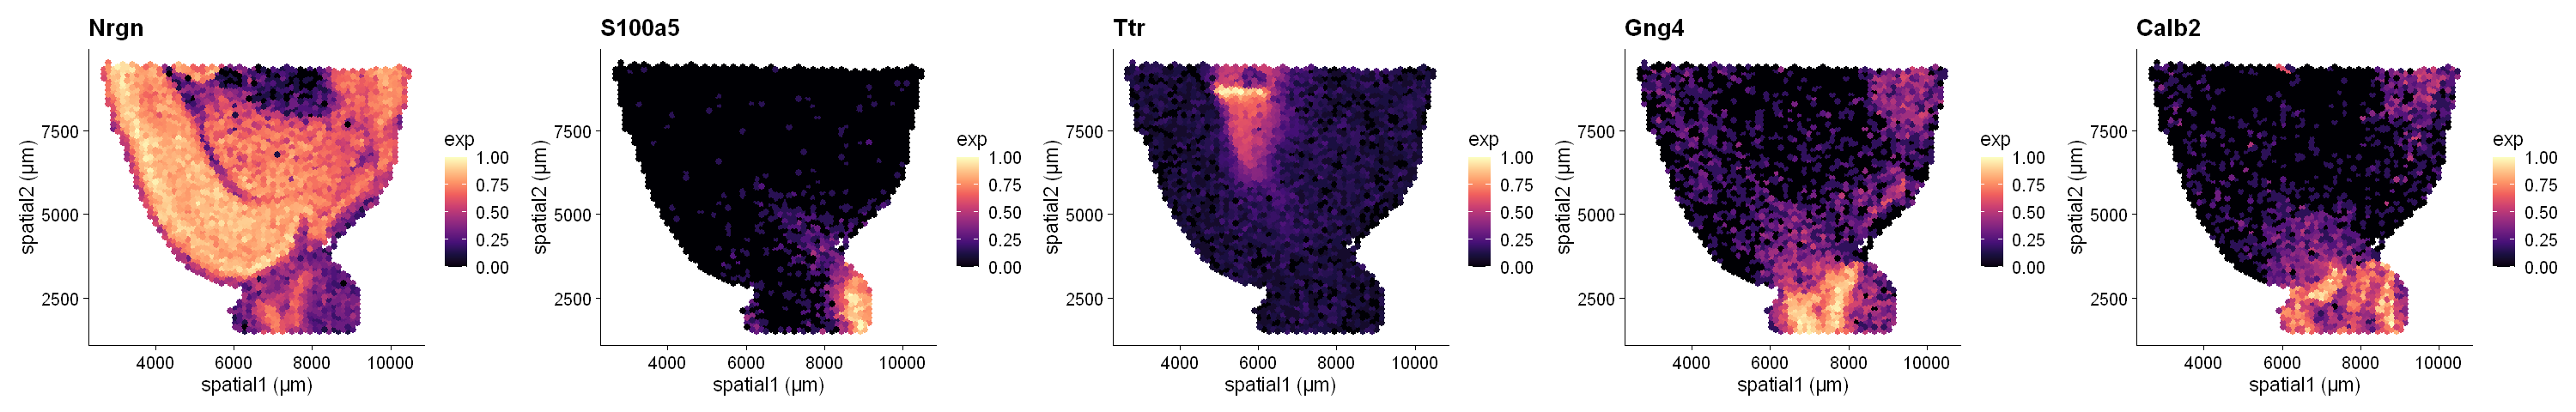

In [10]:
#可视化五个基因的表达分布
suppressMessages(library(SingleCellExperiment))
plot_exp <- function(sce, gene, pt_size=1){
    df_loc <- colData(sce)[, c("spatial1","spatial2")]
    df_exp <- as.data.frame(counts(sce)[gene, ])
    colnames(df_exp) <- c('exp')
    df_exp$exp <- rescale(log1p(df_exp$exp))
    
    df <- cbind(df_exp, df_loc)
    
    p <- ggplot(data = df, aes(x = spatial1, y = spatial2)) +
        geom_point(aes(color = exp), size = pt_size) +
        scale_colour_gradientn(colors = viridis_pal(option = "magma")(10), limits=c(0, 1)) +
        theme_cowplot() +
        labs(x = "spatial1 (μm)", y = "spatial2 (μm)") +   # 添加坐标单位
        ggtitle(gene)
    
    return(p)
}


suppressMessages(library(patchwork))

options(repr.plot.height = 4, repr.plot.width = 25)

gene_list <- rownames(ref_sce)[5:1]
plot_list <- lapply(gene_list, function(gene) {
    plot_exp(ref_sce, gene = gene, pt_size = 1.7)
})

# 横向拼图
wrap_plots(plot_list, ncol = 5)

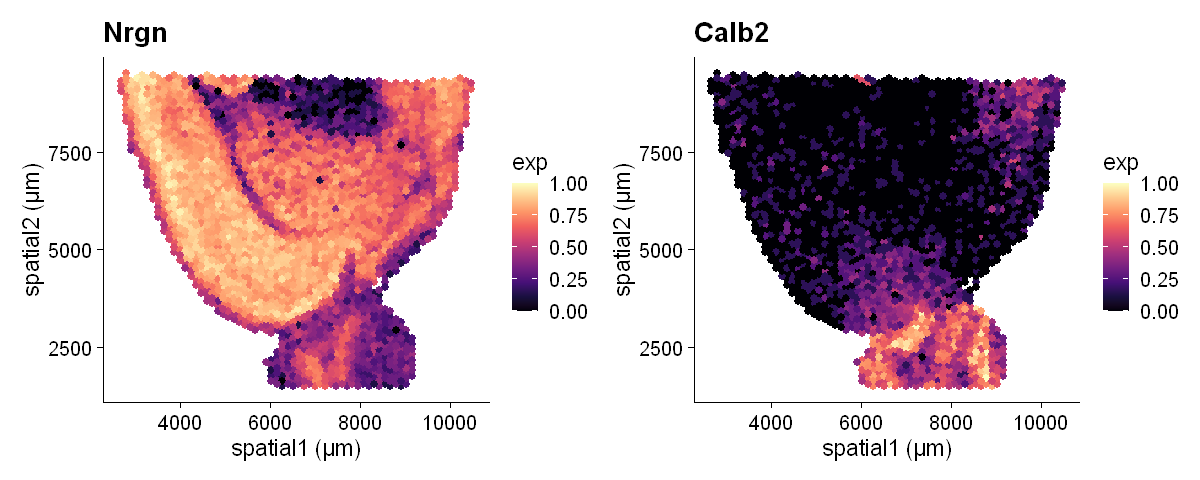

In [11]:
options(repr.plot.height = 4, repr.plot.width = 10)
library(patchwork)

p1 <- plot_exp(ref_sce, gene = "Nrgn", pt_size = 1.7)
p2 <- plot_exp(ref_sce, gene = "Calb2", pt_size = 1.7)

print(p1 + p2)

In [12]:
set.seed(2024)

In [ ]:
# 加载基础包（进度条依赖utils包，无需额外安装）
library(utils)

# 1. 构建用于边际拟合的数据（添加进度提示，因construct_data无迭代，打印执行状态）
cat("开始构建边际拟合的输入数据...\n")
ref_data <- construct_data(
    sce = ref_sce,
    assay_use = "counts",
    celltype = "cell_type",
    pseudotime = NULL,
    spatial = c("spatial1", "spatial2"),
    other_covariates = NULL,
    corr_by = "1"
)
cat("✅ 输入数据构建完成！\n\n")

# 2. 用高斯过程模型拟合每个基因的表达（fit_marginal无直接迭代，打印进度提示）
cat("开始用高斯过程模型拟合每个基因的表达（n_cores=2）...\n")
ref_marginal <- fit_marginal(
    data = ref_data,
    predictor = "gene",
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k = 500)", 
    sigma_formula = "1",
    family_use = "nb",
    n_cores = 2,
    usebam = FALSE,
    trace = TRUE  # 保留原trace参数，输出模型拟合的原始日志
)
cat("✅ 基因表达模型拟合完成！\n\n")

# 3. 计算每个基因模型的解释度（deviance explained）+ 进度条
cat("开始计算每个基因模型的解释度...\n")
n_gene <- length(ref_marginal)  # 获取基因总数
pb <- txtProgressBar(min = 0, max = n_gene, style = 3)  # 创建进度条（style=3最直观）

dev_explain <- sapply(seq_along(ref_marginal), function(i){
  x <- ref_marginal[[i]]
  sum_res <- summary(x$fit)  # 变量名从sum改为sum_res，避免与base::sum冲突
  setTxtProgressBar(pb, i)   # 更新进度条
  return(sum_res$dev.expl)   
})
close(pb)  # 关闭进度条
cat("\n✅ 解释度计算完成！\n\n")
names(dev_explain) <- names(ref_marginal)  # 为解释度向量命名

# 4. 按解释度从高到低排序（无迭代，直接执行）
dev_ordered <- order(dev_explain, decreasing = TRUE)

# 5. 设定要选取的高变基因数量（自动适配基因数，避免越界）
num_de <- min(50, length(dev_explain))  

# 6. 得到排序后的解释度向量
ordered <- dev_explain[dev_ordered]

# 7. 选出前num_de个高变基因的名称
sel_genes <- names(ordered)[1:num_de]
cat(paste0("已按解释度排序，选取前", num_de, "个高变基因：", paste(sel_genes, collapse = ", "), "\n\n"))

# 8. 提取这些基因的参数（extract_para无直接迭代，打印进度提示+核心参数）
cat("开始提取高变基因的参数（n_cores=5，family_use=nb）...\n")
ref_para <- extract_para(
    sce = ref_sce,
    marginal_list = ref_marginal,
    n_cores = 5,
    family_use = "nb",
    new_covariate = ref_data$newCovariate,
    data = ref_data$dat
)
cat("✅ 高变基因参数提取完成！\n\n")

# （可选）重复计算解释度的备用代码（原代码中重复的解释度计算，保留并加进度条）
cat("【备用步骤】重新计算每个基因模型的解释度（带进度条）...\n")
n_gene_dup <- length(ref_marginal)
pb_dup <- txtProgressBar(min = 0, max = n_gene_dup, style = 3)

dev_explain_dup <- sapply(seq_along(ref_marginal), function(i){
  x <- ref_marginal[[i]]
  sum_res_dup <- summary(x$fit)
  setTxtProgressBar(pb_dup, i)
  return(sum_res_dup$dev.expl)   
})
close(pb_dup)
cat("\n✅ 备用步骤-解释度重新计算完成！\n\n")

names(dev_explain_dup) <- names(ref_marginal)
dev_ordered_dup <- order(dev_explain_dup, decreasing = TRUE)
num_de_dup <- min(50, length(dev_explain_dup))
ordered_dup <- dev_explain_dup[dev_ordered_dup]
sel_genes_dup <- names(ordered_dup)[1:num_de_dup]
cat(paste0("【备用步骤】已选取前", num_de_dup, "个高变基因：", paste(sel_genes_dup, collapse = ", "), "\n"))
cat("\n🎉 所有分析步骤执行完成！\n")

In [ ]:
ref_sce <- ref_sce[sel_genes, ]